<a href="https://colab.research.google.com/github/stevejobs1524/Credify/blob/main/credify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Install required packages
!pip install torch-scatter torch-sparse torch-geometric -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.8 MB/s eta 0:00:00


In [ ]:
# Step 2: Import necessary libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data


In [ ]:
# Step 3: Define the GCN model class
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [ ]:
# Step 4: Create a toy dataset (4 nodes with 3 features each)
x = torch.tensor([
    [0.2, 0.1, 0.5],  # Node 0
    [0.8, 0.9, 0.3],  # Node 1
    [0.4, 0.2, 0.6],  # Node 2
    [0.9, 0.7, 0.1],  # Node 3
], dtype=torch.float)

# Define edges between the nodes (undirected graph)
edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3],  # source nodes
    [1, 0, 2, 1, 3, 2],  # target nodes
], dtype=torch.long)

# Labels: 0 = Real account, 1 = Fake account
y = torch.tensor([0, 1, 0, 1], dtype=torch.long)

# Training and testing masks
train_mask = torch.tensor([True, True, False, False])
test_mask = torch.tensor([False, False, True, True])

# Package into a PyTorch Geometric Data object
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)


In [ ]:
# Step 5: Define training function
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


In [ ]:
# Step 6: Define evaluation function
def evaluate(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)

    test_pred = pred[data.test_mask]
    test_labels = data.y[data.test_mask]

    accuracy = (test_pred == test_labels).sum().item() / len(test_labels)
    print("Evaluation Results:")
    print("Accuracy:", round(accuracy, 4))
    print("Predicted Labels:", test_pred.tolist())
    print("Actual Labels:   ", test_labels.tolist())


In [ ]:
# Step 7: Initialize model, optimizer, and loss function
model = GCN(num_features=3, hidden_channels=4, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

print("Data prepared.")
print("Fake accounts in train set:", data.y[data.train_mask].sum().item())
print("Fake accounts in test set:", data.y[data.test_mask].sum().item())


Data prepared.
Fake accounts in train set: 1
Fake accounts in test set: 1


In [ ]:
# Step 9: Evaluate model performance
evaluate(model, data)


Evaluation Results:
Accuracy: 0.5
Predicted Labels: [0, 0]
Actual Labels:    [0, 1]


<ipython-input-14-ccf960eb20be>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


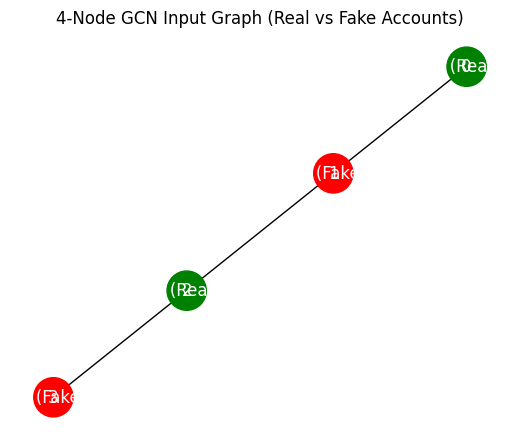

In [ ]:
# Re-run the graph visualization code after kernel reset

import matplotlib.pyplot as plt
import networkx as nx

# Define the graph structure
edges = [(0, 1), (1, 2), (2, 3)]
labels = {0: "Real", 1: "Fake", 2: "Real", 3: "Fake"}

# Create a networkx graph
G = nx.Graph()
G.add_edges_from(edges)

# Define node colors based on label
node_colors = ['green' if labels[node] == "Real" else 'red' for node in G.nodes]

# Draw the graph
plt.figure(figsize=(5, 4))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800, font_color='white')
nx.draw_networkx_labels(G, pos, labels={i: f"{i} ({labels[i]})" for i in G.nodes}, font_color='white')
plt.title("4-Node GCN Input Graph (Real vs Fake Accounts)")
plt.axis('off')
plt.tight_layout()
plt.show()
